In [1]:
from models.det_allhist_glm2 import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
C_syn_e_file = "handsub5.5_C_syn_e.npy"
C_syn_i_file = "handsub5.5_C_syn_i.npy"
C_den_file = "handsub5.5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 4800
epoch_no = 16
layer_no = 3

In [4]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

162


In [ ]:
t = torch.arange(T_no+1).to(device)
t_tau = t / 5
kern = t_tau * torch.exp(-t_tau)
kern = torch.flip(kern, [0])

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
    
    filt_batch_Z = F.conv1d(batch_Z.reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
    filt_pred_Z = F.conv1d(Z_pred[:,0].reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
    
        
    loss = torch.mean((filt_batch_Z - filt_pred_Z)**2)
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural)
        
        filt_test_Z = F.conv1d(Z_test.reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
        filt_test_pred_Z = F.conv1d(test_Z_pred[:,0].reshape(1,1,-1), kern.reshape(1,1,-1), padding=T_no//2).flatten()
         
        test_loss = torch.mean((filt_test_Z - filt_test_pred_Z)**2).item()
        test_P = torch.mean(test_P_pred[:,0]).item()
        
        print(i, test_loss, test_P, torch.sum(test_Z_pred).item())


<ipython-input-6-4c6bbe171dc1>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 0.04640825092792511 0.4713784158229828 1864.0
199 0.03581329807639122 0.4728809893131256 1767.0
299 0.031116049736738205 0.4732351005077362 1636.0
399 0.025199273601174355 0.47383826971054077 1522.0
499 0.01937573030591011 0.4744310677051544 1411.0
599 0.015969231724739075 0.47448399662971497 1324.0
699 0.0141654834151268 0.4742513597011566 1279.0
799 0.012885197065770626 0.47342589497566223 1274.0
899 0.011466151103377342 0.4731143116950989 1233.0
999 0.010710629634559155 0.4723626375198364 1190.0
1099 0.009384027682244778 0.47240984439849854 1099.0
1199 0.009090028703212738 0.47164908051490784 1120.0
1299 0.00811210460960865 0.4712543487548828 1126.0
1399 0.0075964475981891155 0.47065499424934387 1107.0
1499 0.0062886448577046394 0.4708532392978668 1045.0
1599 0.005975794512778521 0.47043296694755554 1015.0
1699 0.005773006472736597 0.4698531925678253 1105.0
1799 0.005331631749868393 0.4696502983570099 1063.0
1899 0.005053970031440258 0.469282865524292 1104.0
1999 0.00437979726120

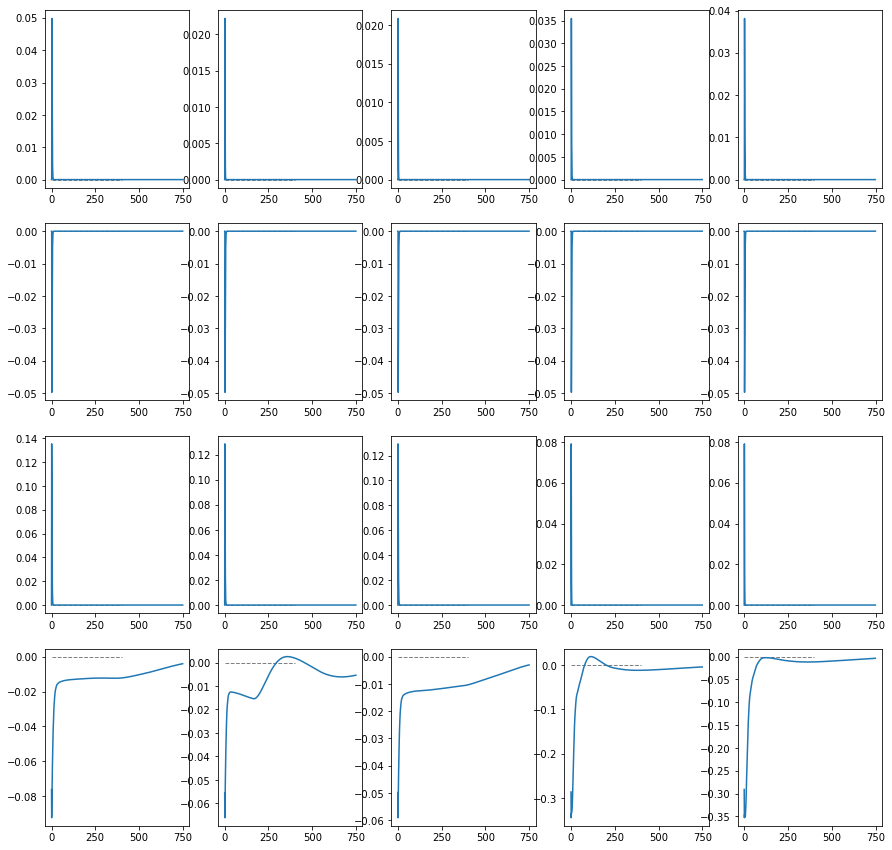

In [7]:
sub_no = 6
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)
-0.5964068174362183


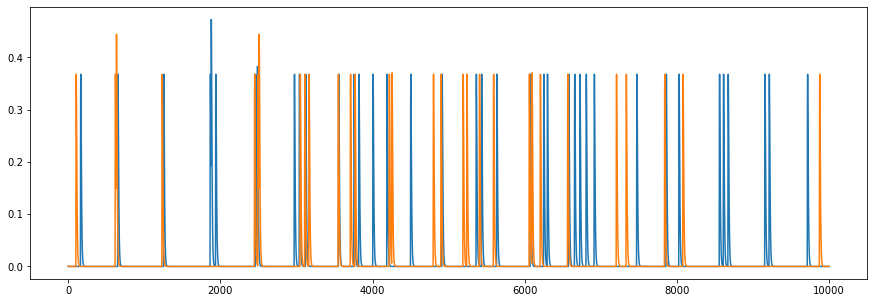

In [8]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:26000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:26000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))
print(explained_variance_score(filt_test_Z.cpu().detach().numpy(), filt_test_pred_Z.cpu().detach().numpy()))

tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)


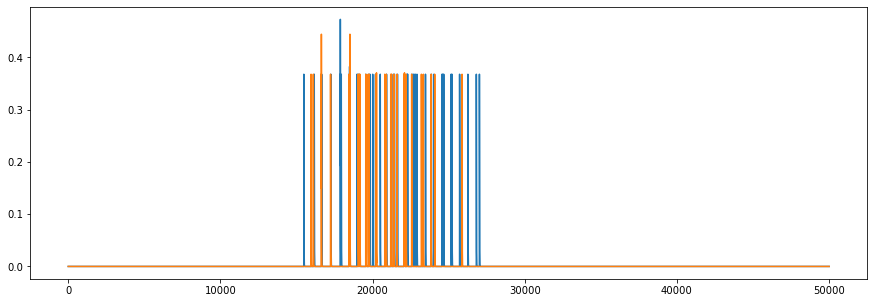

In [9]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[:])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[:])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))

In [10]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Tau_syn tensor([[ 0.0000,  0.0000],
        [-0.6160,  0.0000],
        [-0.6418,  0.0000],
        [-0.2758,  0.0000],
        [-0.2160,  0.0000]], device='cuda:0')
Delta_syn tensor([[ 0.0000e+00,  0.0000e+00],
        [-9.8171e-05,  0.0000e+00],
        [ 7.7111e-04,  0.0000e+00],
        [-1.0491e-03,  0.0000e+00],
        [ 4.8245e-03,  0.0000e+00]], device='cuda:0')
W_syn tensor([[-2.0000, -2.0000],
        [-2.5744, -2.0000],
        [-2.6164, -2.0000],
        [-2.2975, -2.0000],
        [-2.2426, -2.0000]], device='cuda:0')
Tau_spk tensor([ 0.0000, -0.0456, -0.0400, -0.4315, -0.4329], device='cuda:0')
Delta_spk tensor([0., 0., 0., 0., 0.], device='cuda:0')
W_spk tensor([-1.0000, -1.0501, -1.0444, -1.4296, -1.4280], device='cuda:0')
W_hist tensor([[-0.0517, -0.0491, -0.0454, -0.0417, -0.0362, -0.0289, -0.0205, -0.0131,
         -0.0089, -0.0076, -0.0072, -0.0068, -0.0066, -0.0064, -0.0061, -0.0061,
         -0.0065],
        [-0.0379, -0.0356, -0.0324, -0.0295, -0.0252, -0.0198,

tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)


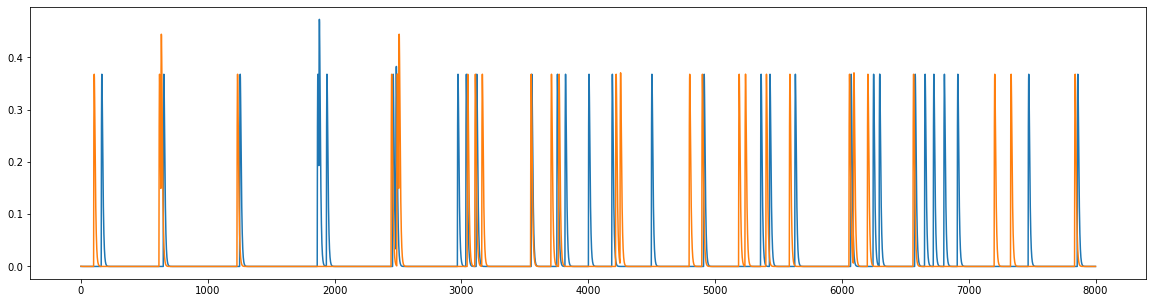

In [12]:
plt.figure(figsize=(20,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:24000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:24000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))

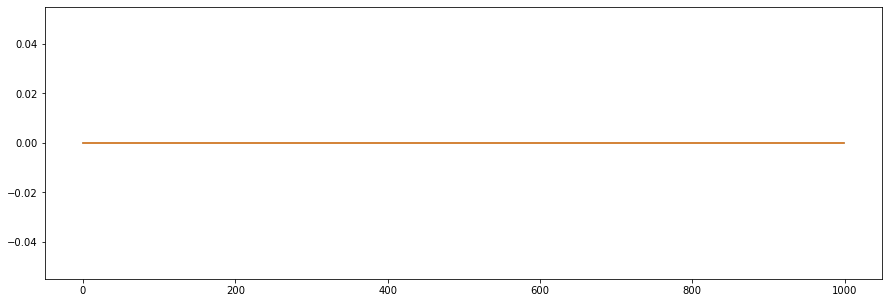

In [8]:
plt.figure(figsize=(15,5))
plt.plot(filt_batch_Z.cpu().detach().numpy()[:])
plt.plot(filt_pred_Z.cpu().detach().numpy()[:])
